In [22]:
import numpy as np
import pandas as pd
import json
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib as mpl
from adjustText import adjust_text
from matplotlib.lines import Line2D

In [23]:
with open("starwars-full-interactions-allCharacters-merged.json", "r") as file:
    data = json.load(file)

# Konwersja do DataFrame
#df = pd.DataFrame(data)

# Wyświetlenie DataFrame
edgelist_df=pd.DataFrame(data.get("links"))
nodes=pd.DataFrame(data.get("nodes")).iloc[:,[0,1]]
edgelist_df.columns=['source', 'target', 'weight']
nodes["label"]=nodes["name"].str.replace(' ', '_')


In [24]:
edgelist_df

,source,target,weight
0,0,1,32
1,2,0,2
2,0,20,5
3,0,4,22
4,0,18,41
...,...,...,...
439,108,109,2
440,93,106,1
441,108,106,1
442,69,98,1


In [25]:
nodes["Id"]=nodes.index
nodes

,name,value,label,Id
0,DARTH VADER,190,DARTH_VADER,0
1,R2-D2,171,R2-D2,1
2,CHEWBACCA,145,CHEWBACCA,2
3,BB-8,40,BB-8,3
4,QUI-GON,62,QUI-GON,4
...,...,...,...,...
106,YOLO ZIFF,4,YOLO_ZIFF,106
107,COLONEL DATOO,4,COLONEL_DATOO,107
108,ELLO ASTY,5,ELLO_ASTY,108
109,JESS,5,JESS,109


In [26]:
sw_graph = nx.from_pandas_edgelist(edgelist_df, "source", "target", edge_attr="weight")

In [27]:
node_labels_dict = nodes.set_index("Id")["name"].to_dict()
nx.relabel_nodes(sw_graph, node_labels_dict, copy=False) # zmiana nazw wierzchołków na podstawie słownika 

In [28]:
weights = np.array([e[2]["weight"] for e in sw_graph.edges(data=True)])
max_weight = np.max(weights)

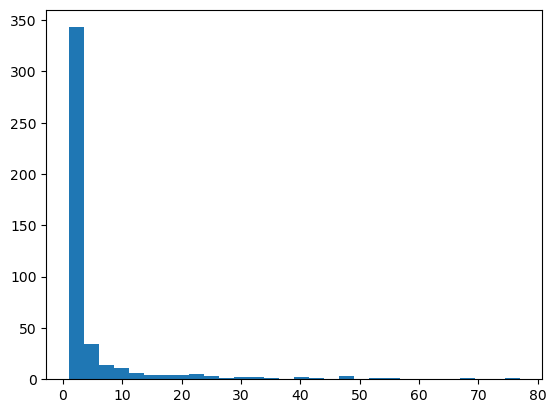

In [29]:
plt.hist(weights, bins=30) # pomocniczy wykres do ustalenia legendy szerokości krawędzi
plt.show()

In [30]:
# do ustalenia wielkości wierzchołków
node_degree = dict(sw_graph.degree(weight = "Weight"))
node_size = np.array([node_degree[n] for n in sw_graph.nodes()])

In [31]:
pos = nx.kamada_kawai_layout(sw_graph)
pos = {node: (y, x*2) for node, (x, y) in pos.items()}

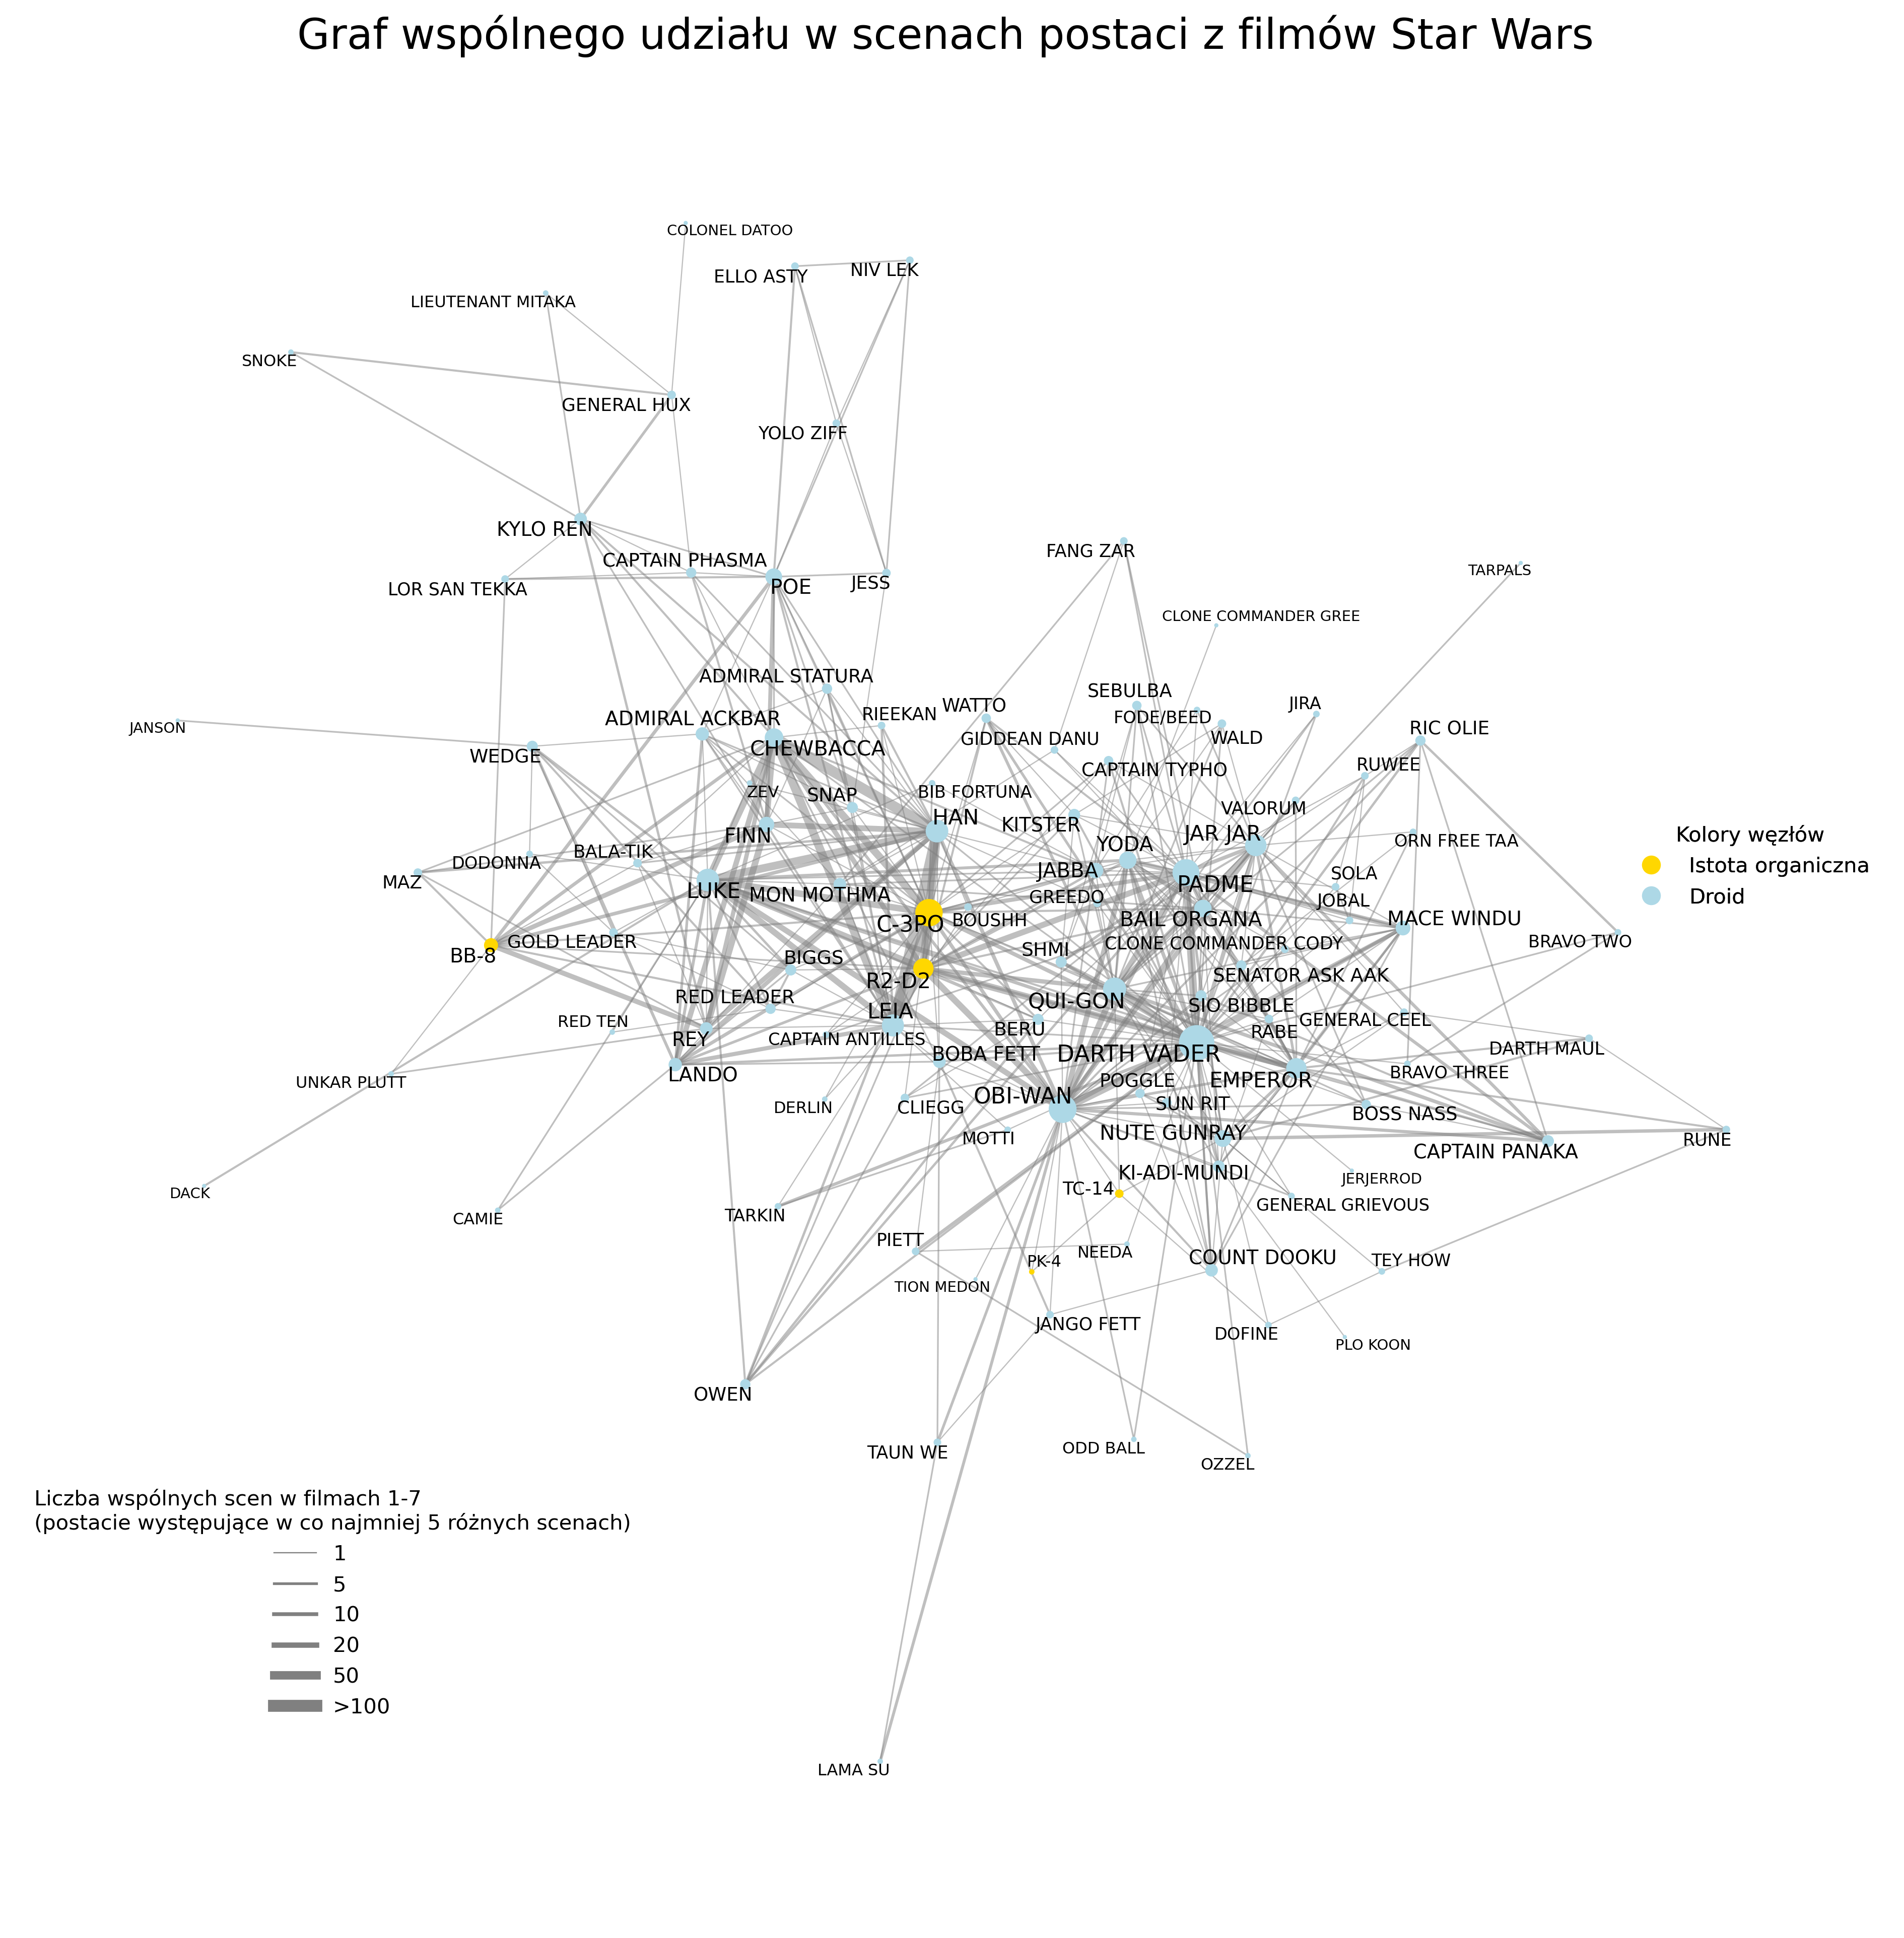

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16), dpi = 300)

# rysowanie warstwowo w celu lepszej kontroli (np. różny poziom przezroczystości)
ax.set_title("Graf wspólnego udziału w scenach postaci z filmów Star Wars ", fontsize=20)

node_colors = ["gold" if any(char.isdigit() for char in str(node)) else "lightblue" for node in sw_graph.nodes]

nx.draw_networkx_nodes(sw_graph, 
    pos=pos, 
    node_color=node_colors, 
    node_size=node_size**1.4, 
    ax=ax
)

nx.draw_networkx_edges(
    sw_graph,
    pos=pos,
    width=np.sqrt(weights / max_weight) * 5,
    edge_color="gray",
    alpha=0.5, # półprzezroczyste krawędzie
    ax=ax,
)

#for i, (node, (x, y)) in enumerate(pos.items()):
 #   ax.text(x, y - 0.02, node, fontsize=7 + np.log(node_size[i]), ha="center", va="center")

for w in [1, 5, 10, 20, 50]:
    ax.plot([], [], "gray", linewidth=np.sqrt(w) / np.sqrt(max_weight) * 5, label= w )
ax.plot([], [], "gray", linewidth=np.sqrt(100) / np.sqrt(max_weight) * 5, label=">100")
ax.legend(title="Liczba wspólnych scen w filmach 1-7 \npostacie występujące w co najmniej 5 różnych scenach", frameon=False, bbox_to_anchor=(0, 0.1), loc = "lower left")


texts = []
for i, (node, (x, y)) in enumerate(pos.items()):
    text = ax.text(x, y, str(node), fontsize=7 + np.log(node_size[i]), ha="center", va="center")
    texts.append(text)


adjust_text(
    texts,
    
    expand_text=(1.2, 1.2),  # Minimalny odstęp między tekstami
    expand_points=(1.2, 1.2),  # Minimalny odstęp między tekstem a węzłem
)

color_legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', markersize=10, label='Istota organiczna'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Droid')
]

legend_edges = ax.legend(
    title="Liczba wspólnych scen w filmach 1-7\n(postacie występujące w co najmniej 5 różnych scenach)",
    frameon=False,
    bbox_to_anchor=(0, 0.1),
    loc='lower left'
)
legend_colors = ax.legend(
    handles=color_legend_elements,
    title="Kolory węzłów",
    frameon=False,
    bbox_to_anchor=(1.0, 0.6),  # Ustawienie pozycji nowej legendy
    
)

ax.add_artist(legend_edges)  # Dodanie starej legendy
ax.add_artist(legend_colors)  # Dodanie nowej legendy

plt.axis("off")
plt.savefig("star_wars.jpg")
